Found actions: ['about', 'ask', 'eat', 'feel', 'from', 'happy', 'he_she_it', 'learn', 'like', 'on', 'say', 'see', 'sick', 'sleep', 'try', 'what', 'work']

Datensatz-Balancierung:
Minimum samples pro Klasse: 27
Maximum samples pro Klasse: 39
Klasse 'about': 30 → 27 Samples
Klasse 'ask': 36 → 27 Samples
Klasse 'eat': 39 → 27 Samples
Klasse 'feel': 33 → 27 Samples
Klasse 'from': 30 → 27 Samples
Klasse 'happy': 30 → 27 Samples
Klasse 'he_she_it': 33 → 27 Samples
Klasse 'learn': 27 → 27 Samples
Klasse 'like': 30 → 27 Samples
Klasse 'on': 36 → 27 Samples
Klasse 'say': 36 → 27 Samples
Klasse 'see': 27 → 27 Samples
Klasse 'sick': 33 → 27 Samples
Klasse 'sleep': 36 → 27 Samples
Klasse 'try': 33 → 27 Samples
Klasse 'what': 30 → 27 Samples
Klasse 'work': 30 → 27 Samples

Zusammenfassung des Datensatzes:
Gefunden: 17 Aktionen: ['about' 'ask' 'eat' 'feel' 'from' 'happy' 'he_she_it' 'learn' 'like' 'on'
 'say' 'see' 'sick' 'sleep' 'try' 'what' 'work']
Geladen: 459 Sequenzen (ausgeglichen)
Sequenz-For

/workspaces/asl_detection/.venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/400 - New best model saved!
Epoch 1/400 - Train Loss: 3.3221, Train Acc: 0.0685, Val Loss: 2.8258, Val Acc: 0.0580, LR: 0.000300
Epoch 2/400 - New best model saved!
Epoch 3/400 - New best model saved!
Epoch 4/400 - New best model saved!
Epoch 5/400 - New best model saved!
Epoch 5/400 - Train Loss: 2.7614, Train Acc: 0.1121, Val Loss: 2.6132, Val Acc: 0.2174, LR: 0.000300
Epoch 6/400 - New best model saved!
Epoch 7/400 - New best model saved!
Epoch 8/400 - New best model saved!
Epoch 9/400 - New best model saved!
Epoch 10/400 - New best model saved!
Epoch 10/400 - Train Loss: 2.6222, Train Acc: 0.1931, Val Loss: 2.3332, Val Acc: 0.3188, LR: 0.000300
Epoch 11/400 - New best model saved!
Epoch 12/400 - New best model saved!
Epoch 13/400 - New best model saved!
Epoch 14/400 - New best model saved!
Epoch 15/400 - New best model saved!
Epoch 15/400 - Train Loss: 2.2182, Train Acc: 0.2897, Val Loss: 2.0882, Val Acc: 0.4348, LR: 0.000300
Epoch 16/400 - New best model saved!
Epoch 18/40

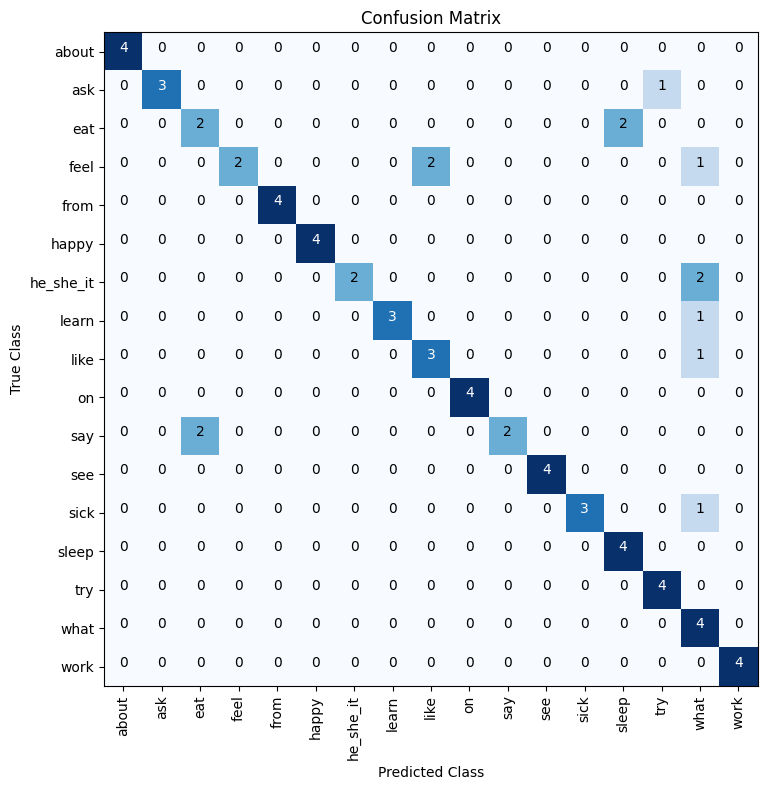

Training metrics saved to /workspaces/asl_detection/machine_learning/Micha/datasets/training_metrics.png


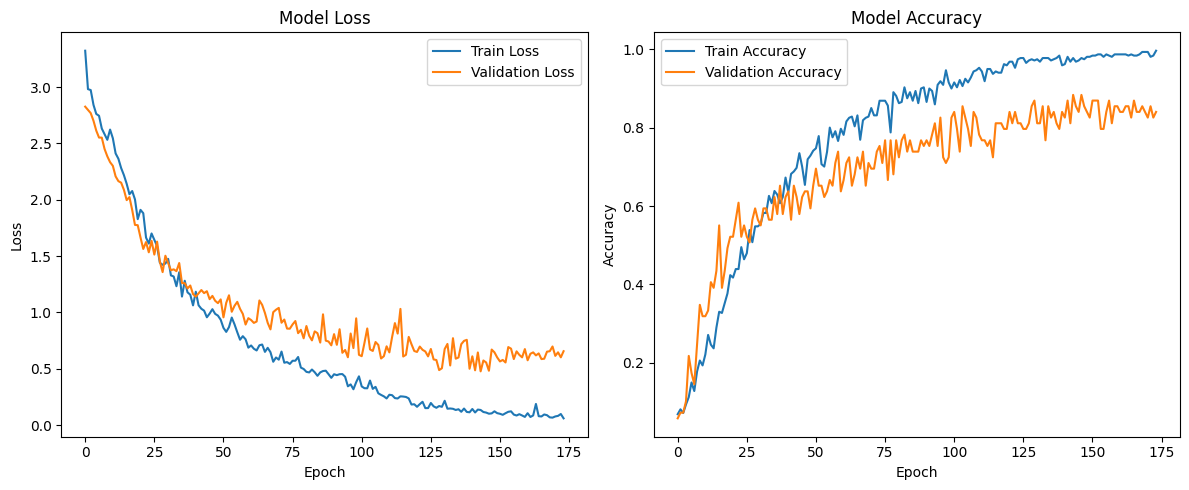

In [1]:
import json
import os

import matplotlib.pyplot as plt
import numpy as np
# import seaborn as sns  # Seaborn wird entfernt
import torch
import torch.nn as nn
from scipy.interpolate import interp1d
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, TensorDataset


def get_available_actions(keypoints_dir="/workspaces/asl_detection/machine_learning/Micha/datasets/keypoints"):
    """Gets all available actions from the keypoints directory."""
    try:
        # Get all JSON files
        json_files = [f for f in os.listdir(keypoints_dir) if f.endswith(".json")]
        if not json_files:
            print(f"No JSON files found in {keypoints_dir}")
            return None

        # Extract unique action names
        actions = set()
        for file in json_files:
            # Load JSON to get the actual action name
            with open(os.path.join(keypoints_dir, file), "r") as f:
                data = json.load(f)
                actions.add(data["gloss"])

        actions = sorted(list(actions))  # Convert to sorted list
        print(f"Found actions: {actions}")
        return np.array(actions)
    except Exception as e:
        print(f"Error loading actions: {e}")
        return None


def load_data(keypoints_dir="/workspaces/asl_detection/machine_learning/Micha/datasets/keypoints", sequence_length=30):
    """Lädt Keypoints und sorgt für ein ausgeglichenes Dataset mit gleicher Anzahl pro Klasse."""
    try:
        # Get actions first
        actions = get_available_actions(keypoints_dir)
        if actions is None:
            return None, None, None

        action_to_idx = {action: idx for idx, action in enumerate(actions)}
        
        # Dictionary, um JSON-Dateien pro Aktion zu sammeln
        action_to_jsons = {action: [] for action in actions}

        # Alle JSON-Dateien verarbeiten und nach Aktionen gruppieren
        json_files = [f for f in os.listdir(keypoints_dir) if f.endswith(".json")]
        for file in json_files:
            try:
                with open(os.path.join(keypoints_dir, file), "r") as f:
                    data = json.load(f)
                    action = data["gloss"]
                    if action in action_to_jsons:
                        action_to_jsons[action].append(file)
            except Exception as e:
                print(f"Fehler beim Verarbeiten von {file}: {str(e)}")
                continue
        
        # Finde die minimale Anzahl von Dateien pro Klasse
        min_samples = min([len(files) for files in action_to_jsons.values()])
        max_samples = max([len(files) for files in action_to_jsons.values()])
        
        print(f"\nDatensatz-Balancierung:")
        print(f"Minimum samples pro Klasse: {min_samples}")
        print(f"Maximum samples pro Klasse: {max_samples}")
        
        if min_samples < 10:
            print(f"WARNUNG: Einige Klassen haben sehr wenige Samples ({min_samples})!")
            print(f"Überprüfe die Klassen mit wenigen Samples:")
            for action, files in action_to_jsons.items():
                if len(files) <= min_samples + 5:
                    print(f"  - {action}: {len(files)} Samples")
        
        # Begrenzen der Anzahl von Dateien pro Klasse auf die minimale Anzahl
        balanced_files = {}
        for action, files in action_to_jsons.items():
            # Zufällig genau min_samples auswählen, um Ausgewogenheit zu garantieren
            if len(files) > min_samples:
                balanced_files[action] = np.random.choice(files, min_samples, replace=False)
            else:
                balanced_files[action] = files
            print(f"Klasse '{action}': {len(files)} → {len(balanced_files[action])} Samples")

        # Indizes für Hand-Keypoints
        LEFT_HAND_START = 468 + 33  # Nach Gesicht (468) und Pose (33)
        RIGHT_HAND_START = LEFT_HAND_START + 21  # Linke Hand hat 21 Punkte

        # Indizes für Hand-Keypoints (beide Hände)
        hand_indices = []
        # Linke Hand (21 Punkte * 3 Koordinaten)
        for i in range(LEFT_HAND_START * 3, (LEFT_HAND_START + 21) * 3):
            hand_indices.append(i)
        # Rechte Hand (21 Punkte * 3 Koordinaten)
        for i in range(RIGHT_HAND_START * 3, (RIGHT_HAND_START + 21) * 3):
            hand_indices.append(i)

        # Sequenzen laden
        sequences = []
        labels = []

        # Nur die ausgewählten, balancierten Dateien verarbeiten
        for action, files in balanced_files.items():
            for file in files:
                try:
                    with open(os.path.join(keypoints_dir, file), "r") as f:
                        data = json.load(f)
                        keypoints = np.array(data["keypoints"], dtype=np.float32)

                        if len(keypoints.shape) == 1:
                            keypoints = keypoints.reshape(1, -1)

                        # Nur Hand-Keypoints filtern
                        keypoints = keypoints[:, hand_indices]

                        # Sequenzlänge handhaben
                        if len(keypoints) >= sequence_length:
                            keypoints = keypoints[-sequence_length:]
                        else:
                            padding = np.tile(
                                keypoints[0], (sequence_length - len(keypoints), 1)
                            )
                            keypoints = np.vstack([padding, keypoints])

                        sequences.append(keypoints)
                        labels.append(action_to_idx[action])

                except Exception as e:
                    print(f"Fehler beim Verarbeiten von {file}: {str(e)}")
                    continue

        if not sequences:
            print("Keine gültigen Sequenzen gefunden!")
            return None, None, None

        sequences = np.array(sequences, dtype=np.float32)
        labels = np.array(labels)

        print("\nZusammenfassung des Datensatzes:")
        print(f"Gefunden: {len(actions)} Aktionen: {actions}")
        print(f"Geladen: {len(sequences)} Sequenzen (ausgeglichen)")
        print(f"Sequenz-Form: {sequences.shape}")
        
        # Überprüfung der Klassenverteilung
        class_counts = np.bincount(labels)
        for i, count in enumerate(class_counts):
            print(f"  - {actions[i]}: {count} Samples")

        return sequences, labels, actions

    except Exception as e:
        print(f"Fehler beim Laden der Daten: {str(e)}")
        return None, None, None


class KeypointAugmentation:
    """Class for augmenting keypoint data."""

    def __init__(
        self, noise_factor=0.03, scale_factor=0.08, translation_factor=0.08, p_time_warp=0.7
    ):
        self.noise_factor = noise_factor            # Von 0.02 auf 0.03 erhöht
        self.scale_factor = scale_factor            # Von 0.05 auf 0.08 erhöht
        self.translation_factor = translation_factor # Von 0.05 auf 0.08 erhöht
        self.p_time_warp = p_time_warp              # Von 0.5 auf 0.7 erhöht

    def add_noise(self, sequence):
        """Add random noise to sequence."""
        noise = np.random.normal(0, self.noise_factor, sequence.shape)
        return sequence + noise

    def apply_scaling(self, sequence):
        """Apply random scaling to sequence."""
        # Generate random scale factor for x, y, z
        scale = np.random.uniform(
            1.0 - self.scale_factor, 1.0 + self.scale_factor, 3
        )

        # Apply scaling to all keypoints
        for i in range(0, sequence.shape[1], 3):  # x, y, z for each keypoint
            sequence[:, i] *= scale[0]  # x
            sequence[:, i + 1] *= scale[1]  # y
            sequence[:, i + 2] *= scale[2]  # z

        return sequence

    def apply_translation(self, sequence):
        """Apply random translation to sequence."""
        # Generate random translation for x, y (we don't translate z as much)
        trans_x = np.random.uniform(-self.translation_factor, self.translation_factor)
        trans_y = np.random.uniform(-self.translation_factor, self.translation_factor)
        trans_z = np.random.uniform(
            -self.translation_factor / 2, self.translation_factor / 2
        )

        # Apply translation to all keypoints
        for i in range(0, sequence.shape[1], 3):  # x, y, z for each keypoint
            sequence[:, i] += trans_x  # x
            sequence[:, i + 1] += trans_y  # y
            sequence[:, i + 2] += trans_z  # z

        return sequence

    def apply_time_warp(self, sequence):
        """Apply random time warping to sequence."""
        if np.random.rand() > self.p_time_warp:
            return sequence

        # Original time points and warped time points
        seq_len = sequence.shape[0]
        orig_time = np.arange(seq_len)
        num_control_points = 4
        control_points = np.linspace(0, seq_len - 1, num_control_points)
        warped_control_points = control_points + np.random.uniform(
            -seq_len * 0.05, seq_len * 0.05, num_control_points
        )
        warped_control_points[0] = 0  # Keep start and end the same
        warped_control_points[-1] = seq_len - 1

        # Create interpolation function
        warp_func = interp1d(control_points, warped_control_points, kind="cubic")
        warped_time = warp_func(orig_time)

        # Interpolate keypoints based on warped time
        warped_sequence = np.zeros_like(sequence)
        for i in range(sequence.shape[1]):
            func = interp1d(
                orig_time, sequence[:, i], kind="linear", bounds_error=False, fill_value="extrapolate"
            )
            warped_sequence[:, i] = func(warped_time)

        return warped_sequence

    def __call__(self, sequence):
        """Apply all augmentations to sequence."""
        sequence = self.add_noise(sequence)
        sequence = self.apply_scaling(sequence)
        sequence = self.apply_translation(sequence)
        sequence = self.apply_time_warp(sequence)
        return sequence


class SignLanguageModel(nn.Module):
    def __init__(self, num_classes, input_size=126, hidden_size=64):
        super(SignLanguageModel, self).__init__()

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=2,           # Von 1 auf 2 erhöht für komplexere Mustererkennung
            batch_first=True,
            bidirectional=True,
            dropout=0.2             # Dropout zwischen LSTM-Layern hinzugefügt
        )

        # Attention mechanism - Korrigiert für bidirektionales LSTM
        self.attention = nn.Sequential(nn.Linear(hidden_size * 2, 1), nn.Tanh())

        # Fully connected layers with LayerNorm
        self.fc = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.LayerNorm(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),        # Von 0.3 auf 0.5 erhöht zur Reduzierung von Overfitting
            nn.Linear(hidden_size, num_classes),
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.LSTM):
            for name, param in module.named_parameters():
                if "weight" in name:
                    nn.init.orthogonal_(param)
                elif "bias" in name:
                    nn.init.zeros_(param)

    def forward(self, x):
        # LSTM
        lstm_out, _ = self.lstm(x)  # Output hat Dimension [batch, seq_len, hidden_size*2]

        # Attention
        attention_weights = self.attention(lstm_out)
        attention_weights = torch.softmax(attention_weights, dim=1)

        # Weighted sum
        context = torch.sum(attention_weights * lstm_out, dim=1)

        # Classification
        out = self.fc(context)
        return out


def simple_oversample_data(X, y, actions):
    """Balances data by simple duplication of minority classes but with less augmentation."""
    print("\nStarting oversampling with optimierter Augmentierung...")

    # Convert to NumPy arrays if needed
    X = X.numpy() if torch.is_tensor(X) else X
    y = y.numpy() if torch.is_tensor(y) else y

    # Find class with most samples
    class_counts = np.bincount(y)
    max_samples = np.max(class_counts)

    X_balanced = []
    y_balanced = []
    
    # Verbesserte Augmentierung mit stärkeren Parametern
    augmenter = KeypointAugmentation(
        noise_factor=0.03,      # Erhöht für mehr Variabilität
        scale_factor=0.08,      # Erhöht für unterschiedliche Größen
        translation_factor=0.08, # Erhöht für verschiedene Positionen
        p_time_warp=0.7         # Erhöht für mehr zeitliche Verzerrung
    )

    print("\nOversampling Details:")
    for i, action in enumerate(actions):
        # Find samples for this class
        mask = y == i
        class_X = X[mask]
        current_samples = len(class_X)

        print(f"\n{action}:")
        print(f"  Original Samples: {current_samples}")

        # Add original samples
        X_balanced.append(class_X)
        y_balanced.extend([i] * current_samples)

        # Calculate needed additional samples
        samples_needed = max_samples - current_samples
        if samples_needed > 0:
            # Erzeugt neue Samples mit verbesserter Augmentierung für besseres Training
            additional_samples = []
            for _ in range(samples_needed):
                idx = np.random.randint(0, current_samples)
                augmented = augmenter(class_X[idx])
                additional_samples.append(augmented)
                
            additional_samples = np.stack(additional_samples)
            X_balanced.append(additional_samples)
            y_balanced.extend([i] * samples_needed)
            print(f"  Added Samples mit verbesserter Augmentierung: {samples_needed}")
            print(f"  Final Samples: {max_samples}")

    X_balanced = np.concatenate(X_balanced, axis=0)
    y_balanced = np.array(y_balanced)

    # Random permutation
    perm = np.random.permutation(len(y_balanced))
    X_balanced = X_balanced[perm]
    y_balanced = y_balanced[perm]

    return torch.FloatTensor(X_balanced), torch.LongTensor(y_balanced)


def train_model(model, X_train, X_val, X_test, y_train, y_val, y_test, actions):
    """Trains the sign language model."""
    EPOCHS = 400             # Von 300 auf 400 erhöht für längeres Training
    BATCH_SIZE = 16          # Von 32 auf 16 reduziert für stabileres Training
    LEARNING_RATE = 0.0003   # Von 0.0005 auf 0.0003 reduziert für langsameres Lernen
    PATIENCE = 30            # Von 20 auf 30 erhöht für mehr Geduld beim Early Stopping

    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # Optimizer mit erhöhtem Weight Decay für stärkere Regularisierung
    optimizer = torch.optim.AdamW(
        model.parameters(), 
        lr=LEARNING_RATE, 
        weight_decay=0.001   # Von 0.0005 auf 0.001 erhöht für stärkere Regularisierung
    )

    # Klassengewichtung für problematische Klassen
    class_weights = torch.ones(len(actions))
    problematic_classes = ["ask", "like", "he_she_it", "what", "learn"]
    for action in problematic_classes:
        if action in actions:
            idx = np.where(actions == action)[0][0]
            class_weights[idx] = 1.2  # Höhere Gewichtung für problematische Klassen
    
    # Select best device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    # Gewichteter Loss für problematische Klassen
    class_weights = class_weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    print(f"Klassengewichtung aktiviert für: {problematic_classes}")

    # Learning Rate Scheduler mit angepassten Parametern
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode="min", 
        factor=0.7,          # Von 0.5 auf 0.7 geändert für sanftere Reduktion
        patience=10,         # Von 7 auf 10 erhöht 
        verbose=True
    )

    # Move model and data to device
    model = model.to(device)
    X_train = X_train.to(device)
    y_train = y_train.to(device)
    X_val = X_val.to(device)
    y_val = y_val.to(device)
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    # Set up lists to store training metrics
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": [],
        "lr": [],
    }

    # Training setup
    best_val_loss = float("inf")
    best_epoch = 0
    no_improve = 0
    model_save_path = "/workspaces/asl_detection/machine_learning/Micha/model/best_model_micha.pth"

    # Start training
    print("\nStarting training...")
    print(f"Parameter: EPOCHS={EPOCHS}, BATCH_SIZE={BATCH_SIZE}, LEARNING_RATE={LEARNING_RATE}")
    
    for epoch in range(EPOCHS):
        # Training
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            # Gradient clipping hinzugefügt für Stabilität
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()

            # Statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += targets.size(0)
            train_correct += (predicted == targets).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total

        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct = (val_predicted == y_val).sum().item()
            val_acc = val_correct / len(y_val)

        # Learning rate scheduler
        current_lr = optimizer.param_groups[0]["lr"]
        scheduler.step(val_loss)

        # Save metrics
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)
        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["lr"].append(current_lr)

        # Early stopping and model checkpointing
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            no_improve = 0
            torch.save(
                {
                    "epoch": epoch,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": val_loss,
                    "val_acc": val_acc,
                    "train_loss": train_loss,
                    "train_acc": train_acc,
                },
                model_save_path,
            )
            print(f"Epoch {epoch+1}/{EPOCHS} - New best model saved!")
        else:
            no_improve += 1

        # Print progress
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(
                f"Epoch {epoch+1}/{EPOCHS} - "
                f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        # Early stopping
        if no_improve >= PATIENCE:
            print(
                f"Early stopping at epoch {epoch+1}. Best was epoch {best_epoch+1} with val_loss {best_val_loss:.4f}"
            )
            break

    print(f"\nTraining completed. Best epoch: {best_epoch+1} with val_loss: {best_val_loss:.4f}")

    # Load best model with map_location to ensure loading on current device
    try:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        checkpoint = torch.load(model_save_path, map_location=device)
        model.load_state_dict(checkpoint["model_state_dict"])
        print(f"Loaded best model from {model_save_path}")
    except Exception as e:
        print(f"Warning: Could not load best model: {e}")
        print("Continuing with current model state...")

    return model, history


def save_actions_list(actions):
    """Speichert die Liste der erkannten Actions in eine JSON-Datei."""
    import json
    from datetime import datetime
    
    # Daten für die JSON-Datei vorbereiten
    data = {
        "actions": actions.tolist(),
        "creation_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        "model_info": {
            "input_size": 126,  # 21 points * 3 coordinates * 2 hands
            "hidden_size": 64,  # Hidden size des LSTM
            "num_layers": 2     # Auf 2 erhöht, um mit Modellarchitektur übereinzustimmen
        }
    }
    
    # JSON-Datei speichern
    actions_path = "/workspaces/asl_detection/machine_learning/Micha/datasets/actions_list.json"
    with open(actions_path, 'w') as f:
        json.dump(data, f, indent=4)
    
    print(f"Action list saved to {actions_path}")
    
    return actions_path


def evaluate_model(model, X_test, y_test, actions):
    """Evaluates the model on the test set."""
    model.eval()
    with torch.no_grad():
        outputs = model(X_test)
        _, predicted = torch.max(outputs, 1)

        # Convert to NumPy for sklearn metrics
        y_true = y_test.cpu().numpy()
        y_pred = predicted.cpu().numpy()

        # Classification report
        print("\nClassification Report:")
        report = classification_report(y_true, y_pred, target_names=actions)
        print(report)
        
        # Speichert den Report in eine Textdatei
        report_path = "/workspaces/asl_detection/machine_learning/Micha/datasets/classification_report.txt"
        with open(report_path, 'w') as f:
            f.write(report)
        print(f"Classification report saved to {report_path}")

        # Confusion matrix mit matplotlib statt seaborn
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        
        # Matplotlib statt Seaborn für Heatmap
        plt.imshow(cm, interpolation='nearest', cmap='Blues')
        plt.title("Confusion Matrix")
        plt.ylabel("True Class")
        plt.xlabel("Predicted Class")
        
        # Achsenbeschriftungen setzen
        tick_marks = np.arange(len(actions))
        plt.xticks(tick_marks, actions, rotation=90)
        plt.yticks(tick_marks, actions)
        
        # Zahlen in die Zellen einfügen
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                plt.text(j, i, str(cm[i, j]), 
                        horizontalalignment="center",
                        color="white" if cm[i, j] > cm.max() / 2 else "black")
        
        plt.tight_layout()
        
        # Speichert die Confusion Matrix
        cm_path = "/workspaces/asl_detection/machine_learning/Micha/datasets/confusion_matrix.png"
        plt.savefig(cm_path)
        print(f"Confusion matrix saved to {cm_path}")
        plt.show()


def plot_metrics(history):
    """Plots training metrics."""
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Accuracy")
    plt.plot(history["val_acc"], label="Validation Accuracy")
    plt.title("Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    plt.tight_layout()
    
    # Speichert die Metriken
    metrics_path = "/workspaces/asl_detection/machine_learning/Micha/datasets/training_metrics.png"
    plt.savefig(metrics_path)
    print(f"Training metrics saved to {metrics_path}")
    plt.show()


if __name__ == "__main__":
    # Load data dynamically
    sequences, labels, actions = load_data()
    if sequences is None:
        print("Error loading data. Exiting...")
        exit(1)

    # Save the list of actions to JSON
    save_actions_list(actions)

    # Convert to PyTorch tensors
    X = torch.FloatTensor(sequences)
    y = torch.LongTensor(labels)

    # Balance data
    print("\nBalancing data...")
    X_balanced, y_balanced = simple_oversample_data(X, y, actions)

    # Train-Val-Test Split
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_balanced, y_balanced, test_size=0.3, stratify=y_balanced, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )

    # Create and train model
    input_size = 126  # 21 points * 3 coordinates * 2 hands
    model = SignLanguageModel(
        num_classes=len(actions), input_size=input_size, hidden_size=64  # Angepasst auf 64
    )

    model, history = train_model(
        model, X_train, X_val, X_test, y_train, y_val, y_test, actions
    )

    # Evaluate
    evaluate_model(model, X_test, y_test, actions)
    plot_metrics(history) 